In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

In [2]:
train = pd.read_csv('.kaggle/train.csv', parse_dates=['date'])
test = pd.read_csv('.kaggle/test.csv', parse_dates=['date'])
storescsv = pd.read_csv('.kaggle/stores.csv')
oilcsv = pd.read_csv('.kaggle/oil.csv', parse_dates=['date'])
holidayscsv = pd.read_csv('.kaggle/holidays_events.csv',  
        dtype={
            'type': 'category',
            'locale': 'category',
            'locale_name': 'category',
            'description': 'category',
            'transferred': 'bool',
    },
    parse_dates=['date']
)

In [3]:
dfs = {'train':train, 'test':test, 'stores':storescsv, 'oil':oilcsv, 'holidays':holidayscsv}
for name, df in dfs.items():
    print(f'\n{name}\n', df.head())


train
    id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

test
         id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

stores
    store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                   

In [4]:
for name, df in dfs.items():
    print(f'\n{name}\n', df.dtypes)


train
 id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

test
 id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object

stores
 store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

oil
 date          datetime64[ns]
dcoilwtico           float64
dtype: object

holidays
 date           datetime64[ns]
type                 category
locale               category
locale_name          category
description          category
transferred              bool
dtype: object


In [5]:
for name, df in dfs.items():
    print(f'\n{name}\n', df.describe())


train
                  id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01  

test
                  id                 date     sto

In [6]:
for name, df in dfs.items():
    print(f'\n{name}\n', df.isnull().sum())


train
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

test
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

stores
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

oil
 date           0
dcoilwtico    43
dtype: int64

holidays
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


In [7]:
print("Unique stores:", train['store_nbr'].nunique())
print("Unique product families", train['family'].nunique())

Unique stores: 54
Unique product families 33


In [8]:
oilcsv['dcoilwtico'] = oilcsv['dcoilwtico'].ffill()
oilcsv['dcoilwtico'] = oilcsv['dcoilwtico'].bfill()
print(oilcsv.isnull().sum())

date          0
dcoilwtico    0
dtype: int64


In [10]:
store_sales = train.copy()
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

store_sales

id     sales  \
date       store_nbr family                                          
2013-01-01 1         AUTOMOTIVE                        0     0.000   
                     BABY CARE                         1     0.000   
                     BEAUTY                            2     0.000   
                     BEVERAGES                         3     0.000   
                     BOOKS                             4     0.000   
...                                                  ...       ...   
2017-08-15 9         POULTRY                     3000883   438.133   
                     PREPARED FOODS              3000884   154.553   
                     PRODUCE                     3000885  2419.729   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000   
                     SEAFOOD                     3000887    16.000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

In [11]:
sum_sales = store_sales.groupby('date').sum()['sales']
sum_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1684, dtype: float64

In [12]:
total_sales = sum_sales.to_frame()
time = np.arange(len(total_sales.index))
total_sales['time'] = time

X = total_sales.loc[:, ['time']]
y = total_sales.loc[:, 'sales']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

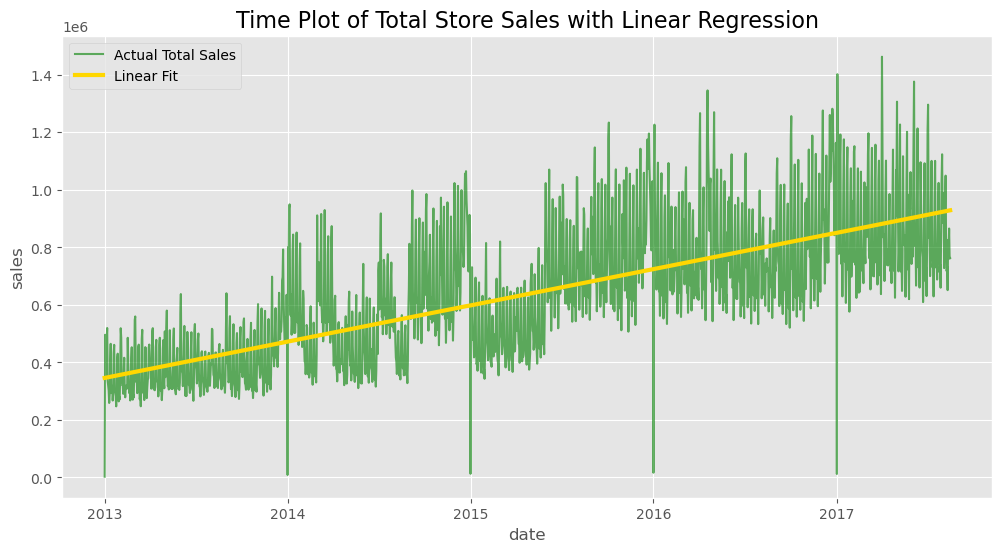

In [13]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(y.to_timestamp(), color='green', alpha=0.6, label='Actual Total Sales')
ax.plot(y_pred, color='gold', linewidth=3, label='Linear Fit')
ax.set_title('Time Plot of Total Store Sales with Linear Regression', fontsize=16)
ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.legend()

plt.show()

In [14]:
lag_1 = total_sales['sales'].shift(1)

total_sales['lag_1'] = lag_1

X = total_sales.loc[:, ['lag_1']]
X.dropna(inplace=True)

y = total_sales.loc[:, 'sales']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)


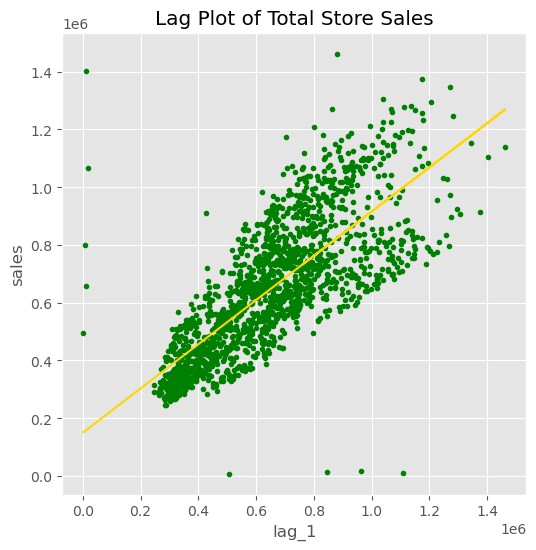

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(X['lag_1'], y, '.', color = 'green')
ax.plot(X['lag_1'], y_pred, color='gold')
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Total Store Sales')

plt.show()

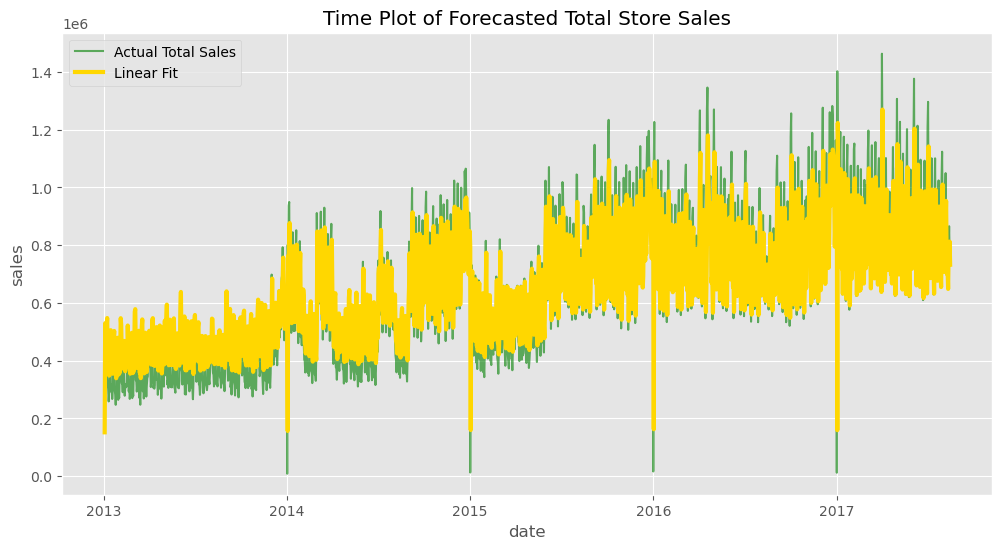

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y.to_timestamp(), color='green', alpha=0.6, label='Actual Total Sales')
ax.plot(y_pred, color='gold', linewidth=3, label='Linear Fit')
ax.set(ylabel='sales', xlabel='date', title='Time Plot of Forecasted Total Store Sales')
ax.legend()

plt.show()

<Axes: title={'center': 'Store Sales - Daily Moving Average'}, xlabel='date'>

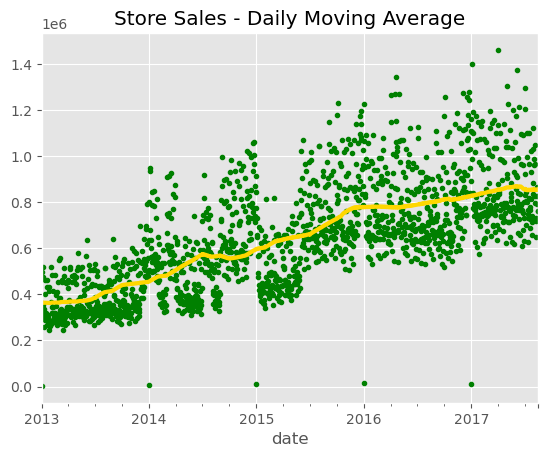

In [17]:
moving_average = sum_sales.rolling(
    window=365, #365 * 4
    center=True,
    min_periods=183,
).mean()

ax = sum_sales.plot(style='.', color='green')
moving_average.plot(
    ax=ax, linewidth=3, title = "Store Sales - Daily Moving Average",color='gold', legend=False,
)

In [18]:
dp = DeterministicProcess(
    index=total_sales.index,
    constant=False,
    order=3,
    drop=True
)

y = total_sales.loc[:,'sales']
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)


model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

X_fore.head()

,trend,trend_squared,trend_cubed
2017-08-16,1685.0,2839225.0,4.784094e+09
2017-08-17,1686.0,2842596.0,4.792617e+09
2017-08-18,1687.0,2845969.0,4.801150e+09
2017-08-19,1688.0,2849344.0,4.809693e+09
2017-08-20,1689.0,2852721.0,4.818246e+09


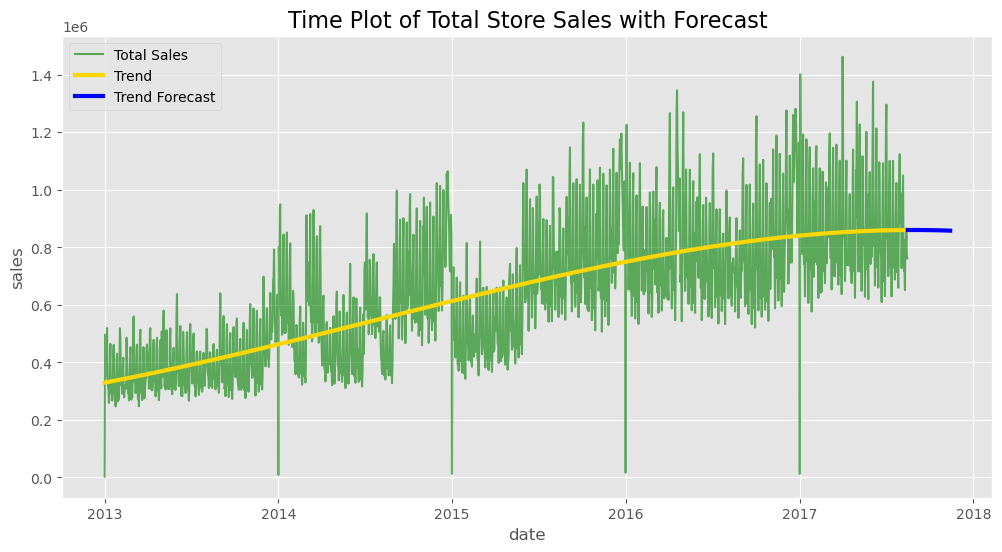

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(y.to_timestamp(), color='green', alpha=0.6, label='Total Sales')
ax.plot(y_pred, color='gold', linewidth=3, label='Trend')
ax.plot(y_fore, color='blue', linewidth=3, label='Trend Forecast')
ax.set_title('Time Plot of Total Store Sales with Forecast', fontsize=16)
ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.legend()

plt.show()

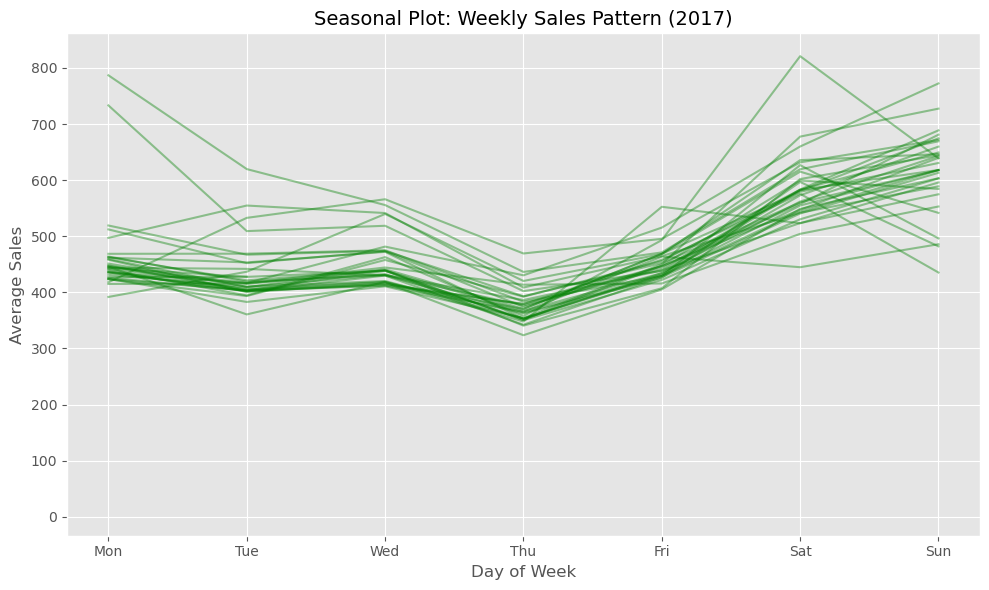

In [20]:
avg_sales_2017 = (store_sales.groupby('date')['sales'].mean().loc['2017'])
avg_sales_2017.index = avg_sales_2017.index.to_timestamp()
df = avg_sales_2017.to_frame()
df['week']= df.index.isocalendar().week
df['dow'] = df.index.dayofweek
pivot = df.pivot(index='dow', columns='week', values='sales')

fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(ax=ax, legend=False, alpha=0.4, color='green')
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_title('Seasonal Plot: Weekly Sales Pattern (2017)', fontsize=14)
ax.set_ylabel('Average Sales')
ax.set_xlabel('Day of Week')
plt.tight_layout()
plt.show()

In [21]:
y = avg_sales_2017.copy()

fourier = CalendarFourier(freq='ME', order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

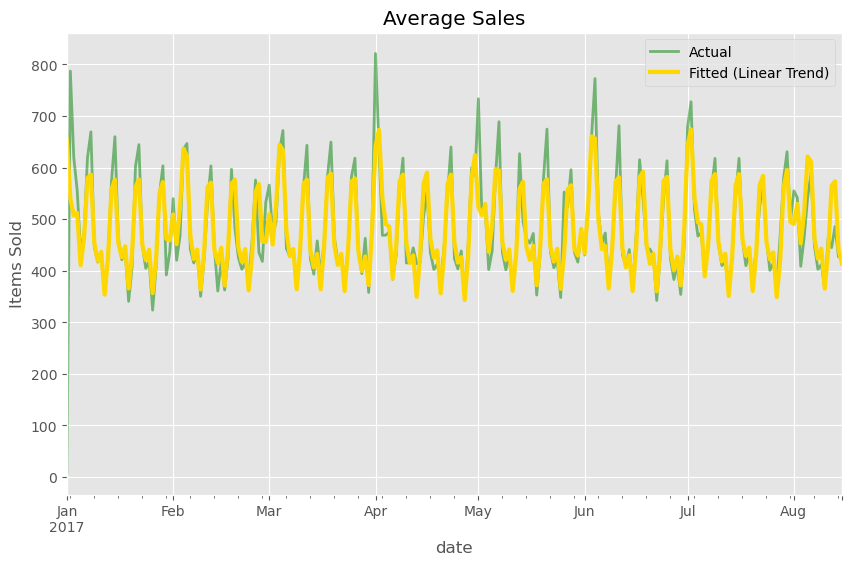

In [22]:
model = LinearRegression().fit(X,y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

fig, ax = plt.subplots(figsize=(10,6))
ax = y.plot( ax=ax, label='Actual', color='green', linewidth=2, alpha=0.5, title='Average Sales', ylabel='Items Sold')
y_pred.plot(ax=ax, label='Fitted (Linear Trend)', color='gold', linewidth=3)
ax.legend();

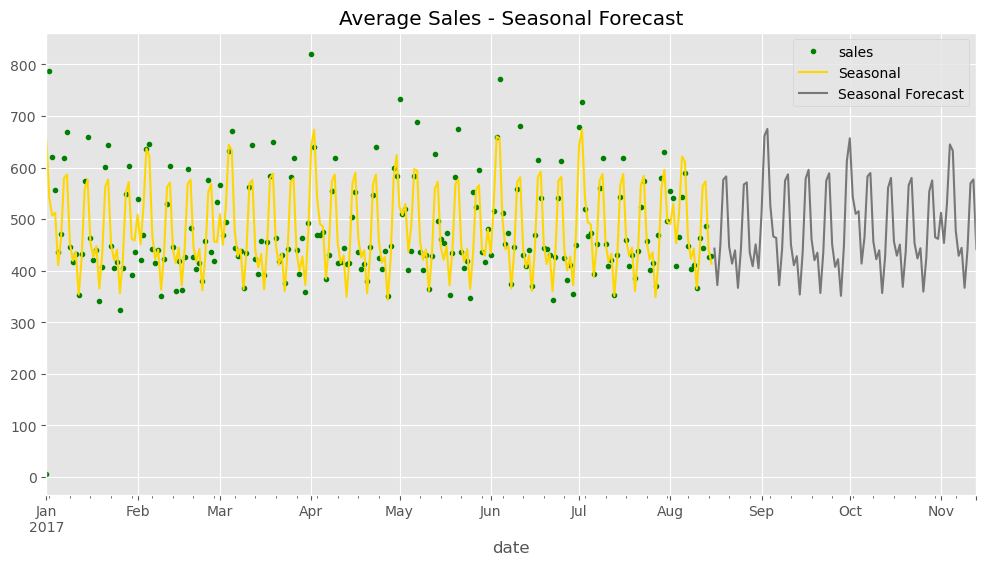

In [23]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

fig, ax = plt.subplots(figsize=(12,6))
ax = y.plot(color='green', style='.', title="Average Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label='Seasonal', color='gold')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

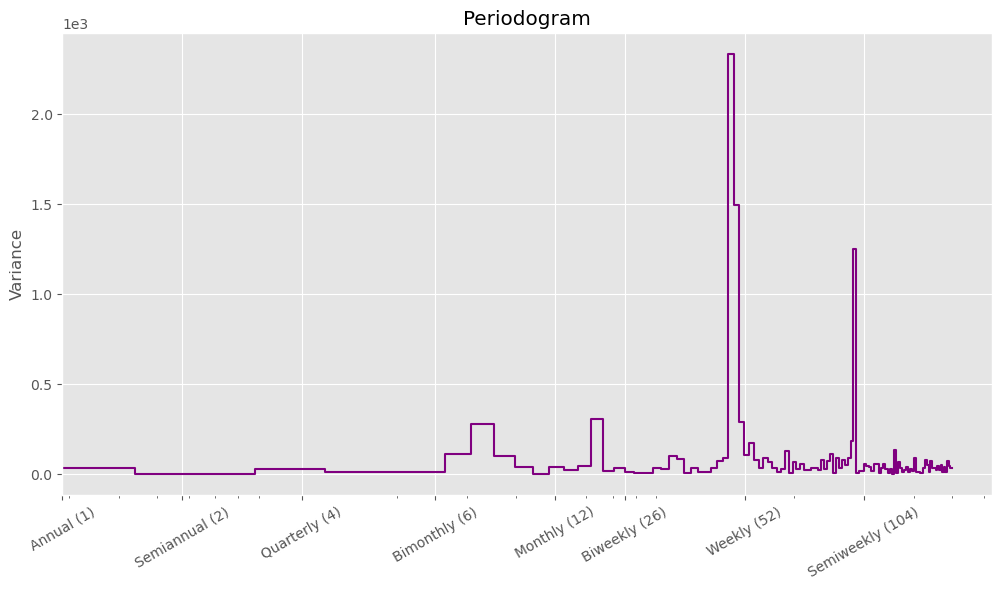

In [24]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    import matplotlib.pyplot as plt
    
    fs = 1  # Daily frequency (1 sample/day)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    
    periods = np.array([1, 2, 4, 6, 12, 26, 52, 104])
    freq_ticks = 1 / periods  # Convert periods to frequencies
    
    periods = np.array([1, 2, 4, 6, 12, 26, 52, 104])
    freq_ticks = 1 / periods
    freq_ticks_shifted = freq_ticks * 0.3
    labels = [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ][::-1]
    
    ax.set_xticks(freq_ticks_shifted)
    ax.set_xticklabels(labels, rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(avg_sales_2017)

Text(0.5, 1.0, 'Deseasonalized')

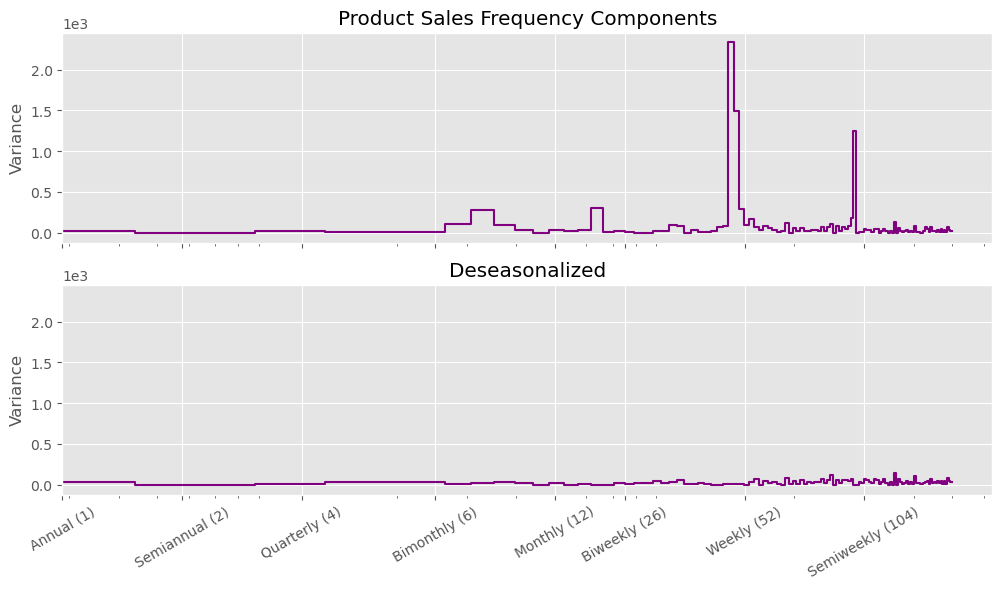

In [25]:
y_deseason = y - y_pred
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,6))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")


In [26]:
holidays = holidayscsv.copy()
holidays = holidays.set_index('date')
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [27]:
holidays = (
    holidays
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


In [28]:
ohe = OneHotEncoder(sparse_output=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=ohe.get_feature_names_out(['description'])
)

X2 = X.join(X_holidays, how='left').fillna(0.0)

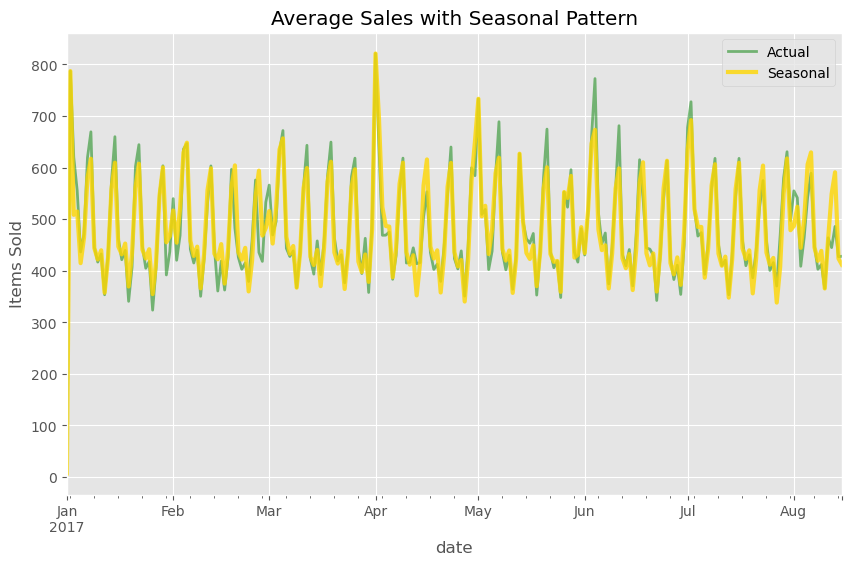

In [29]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=y.index,
    name='Predicted'
)

fig, ax = plt.subplots(figsize=(10,6))
y.plot(
    ax=ax,
    label='Actual',
    color='green',
    linewidth=2,
    alpha=0.5,
    title='Average Sales with Seasonal Pattern',
    ylabel='Items Sold'
)
y_pred.plot(ax=ax, label='Seasonal', color='gold', linewidth=3, alpha=0.8)
ax.legend();

In [30]:
y = store_sales.unstack(['store_nbr', 'family',]).loc['2017']

fourier = CalendarFourier(freq='ME', order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X,y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [31]:
print(test.columns)

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')


In [111]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [119]:
test = pd.read_csv('.kaggle/test.csv',
    dtype={
        'id':'int64',
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'])
df_test = test.copy()
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test
df_test
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'], future_stack=True)
y_submit = y_submit[['id', 'sales']]
y_submit['id'] = (y_submit['id']+1).astype('int64')
y_submit['sales'] = y_submit['sales'].clip(lower=0)
y_submit.to_csv('submission.csv', index=False)

In [99]:
print("Training features:", X.columns)
print("Test features:", X_test.columns)

Training features: Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=ME)', 'cos(1,freq=ME)', 'sin(2,freq=ME)',
       'cos(2,freq=ME)', 'sin(3,freq=ME)', 'cos(3,freq=ME)', 'sin(4,freq=ME)',
       'cos(4,freq=ME)', 'NewYear'],
      dtype='object')
Test features: Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=ME)', 'cos(1,freq=ME)', 'sin(2,freq=ME)',
       'cos(2,freq=ME)', 'sin(3,freq=ME)', 'cos(3,freq=ME)', 'sin(4,freq=ME)',
       'cos(4,freq=ME)', 'NewYear'],
      dtype='object')


In [101]:
print(df_test.index.names)
print(df_test.index.levels)

['store_nbr', 'family', 'date']
[['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '6', '7', '8', '9'], ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], [2017-08-16, 2017-08-17, 2017-08-18, 2017-08-19, 2017-08-20, 2017-08-21, 2017-08-22, 2017-08-23, 2017-08-24, 2017-08-25, 2017-08-26, 2017-08-27, 2017-08-28, 2017